In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=25)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [8]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DOGE

In [9]:
display(df_buy_signal) 

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,MATIC-USD,1.144083023071289,1.220757,1.024891,6.701784
0,SOL-USD,21.032546997070312,23.547815,18.705181,11.958932
0,SHIB-USD,1.1309330147923902e-05,1.2e-05,1e-05,6.107080
0,AVAX-USD,17.61339569091797,18.853632,15.49319,7.041438
0,UNI7083-USD,6.182880878448486,6.809227,5.859555,10.130328


In [10]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [11]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [12]:
display(df_buy_signal)

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,MATIC-USD,1.144083023071289,1.220757,1.024891,6.701784
0,SOL-USD,21.032546997070312,23.547815,18.705181,11.958932
0,SHIB-USD,1.1309330147923902e-05,1.2e-05,1e-05,6.107080
0,AVAX-USD,17.61339569091797,18.853632,15.49319,7.041438
0,UNI7083-USD,6.182880878448486,6.809227,5.859555,10.130328


In [13]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


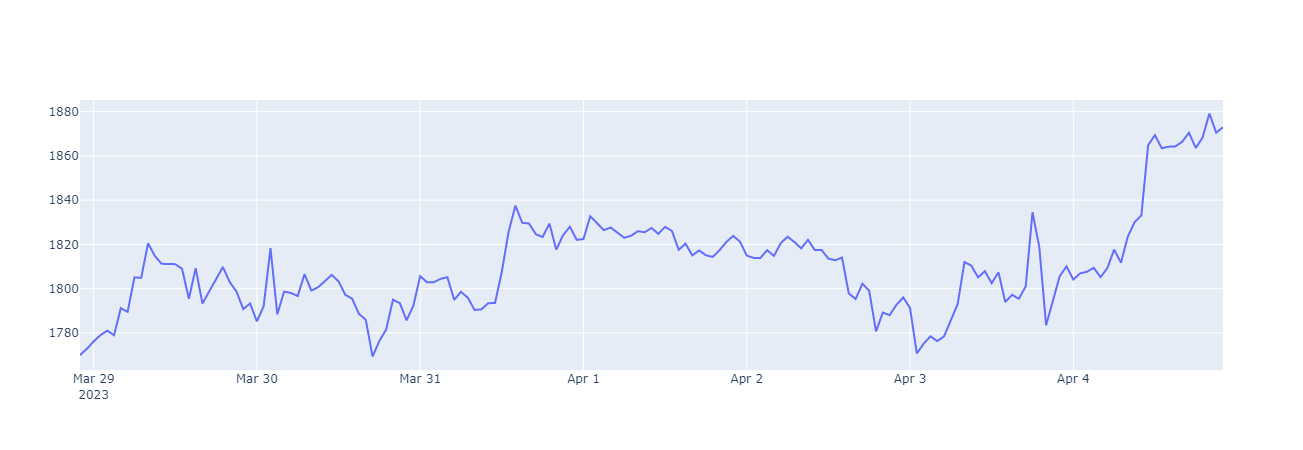

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


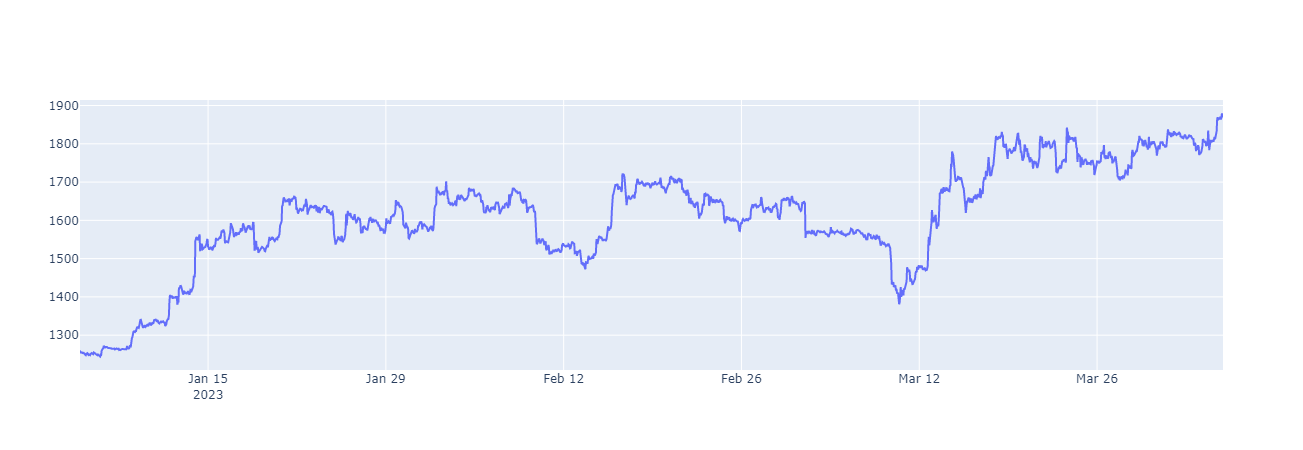

In [14]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [15]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,6076.2918,312.1235,311.3021,-39.4151,67.7364,26.5847,3.8188,1.8146
1,ETH-USD,483.6597,392.1574,1189.6835,-46.8122,49.3345,19.8722,5.8128,3.8111
2,BNB-USD,15549.6815,2455.6927,2153.5971,-30.3840,20.8971,8.0147,-0.1995,0.8661
3,XRP-USD,132.9094,0.9806,178.7346,-38.7671,46.2867,36.0096,-2.8589,3.1323
4,ADA-USD,1126.9554,153.1450,1109.8939,-67.5768,47.7132,17.6191,7.5291,1.9381
5,HEX-USD,45554.3860,45554.3860,17562.6697,-48.0489,315.1061,19.3989,3.3657,0.8057
6,DOGE-USD,6692.2968,3369.7112,5012.2872,-35.3184,32.6932,30.1947,30.8701,3.4330
7,STETH-USD,214.6916,214.6916,214.6916,-47.1328,50.0939,18.8653,5.5197,3.7888


In [16]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-03-29,BTC-USD,28348.441406,28721.299079,26728.059738,1242.790194,1198.632415,Buy
2023-03-30,BTC-USD,28033.5625,28576.620954,26786.90639,1217.846409,1202.475214,Buy
2023-03-31,BTC-USD,28478.484375,28875.038101,26769.974734,1219.91731,1205.963633,Buy
2023-04-01,BTC-USD,28411.035156,29042.966009,26863.854861,1202.257054,1205.222317,Sell
2023-04-02,BTC-USD,28199.308594,29088.280766,26877.105394,1157.829869,1195.743827,Sell
2023-04-03,BTC-USD,27790.220703,28931.866197,27219.329116,1077.19381,1172.033824,Sell
2023-04-04,BTC-USD,28246.283203,28691.597991,27739.06942,1038.122752,1145.25161,Sell
2023-03-29,ETH-USD,1793.001831,1833.58093,1700.459004,43.589135,42.159095,Buy
2023-03-30,ETH-USD,1792.737183,1820.136597,1707.14106,43.860809,42.499438,Buy


In [17]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
               Close
Date                
2019-06-21  3.201412
2019-06-22  2.158967
2019-06-23  1.890702
2019-06-24  1.383728
2019-06-25  1.537290
...              ...
2023-03-30  0.224584
2023-03-31  0.225408
2023-04-01  0.222180
2023-04-02  0.214095
2023-04-04  0.219066

[1383 rows x 1 columns]
1384


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-03-31,0.225408,0.224584,0.220306,0.214404,0.215291,0.215677
2023-04-01,0.222180,0.225408,0.228106,0.217320,0.216374,0.214817
2023-04-02,0.214095,0.222180,0.224057,0.221701,0.216037,0.214136


In [29]:
# RNN Implementation FOR ALGO-USD pair

df_RNN = pd.DataFrame(columns=['Pair','p_units' ,'p_epoch' ,'p_batch_size' ,'prediction'])


df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_alg.index[-1]+ timedelta(days=1)
df_alg.loc[date, :] = [0]


for i in range (1,61):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)

df_alg=df_alg.fillna(0)
display(df_alg)


X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values

print(y.shape)
print(y)
y=y.reshape(-1,1)
print(y)

def calc_LTSM( *param_list ):
    for param in param_list:
        p_units=param[0] 
        p_epoch=param[1]  
        p_batch_size=param[2] 

        # Feature Scaling
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler(feature_range = (0, 1))
        X_scaled = sc.fit_transform(X)
        y_scaled = sc.fit_transform(y)

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=False)
        # Reshaping
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Importing the Keras libraries and packages
        from keras.models import Sequential
        from keras.layers import Dense
        from keras.layers import LSTM
        from keras.layers import Dropout
        regressor = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        # Adding a second LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units, return_sequences = True))
        regressor.add(Dropout(0.2))

        # Adding a fourth LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units))
        regressor.add(Dropout(0.2))

        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
        # Fitting the RNN to the Training set
        regressor.fit(X_train, y_train, epochs = p_epoch, batch_size = p_batch_size)

        lastElementIndex = len(X_test)-1
        # Removing the last element using slicing 
        X_pre = X_test[:lastElementIndex]
        y_pre = y_test[:lastElementIndex]
        X_pre = np.array(X_pre)
        X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1)) #   lenght of dataset,lenght of time_series , nof_input
        predicted_stock_price = regressor.predict(X_pre)
        #print("*****")
        #print(predicted_stock_price)

        index1 = len(X_test)-1
        index2 = len(X_test)
        X_final = X_test[index1:index2]
        y_final = y_test[index1:index2]
        X_final = np.array(X_final)
        X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))

        print(y_final)
        print("Params: "+str(p_units)+" "+str(p_epoch)+" "+str(p_batch_size) )
        predicted_stock_price = regressor.predict(X_final)
        predicted_stock_price_f = sc.inverse_transform(predicted_stock_price)

        row1 = pd.Series(["ALGO-USD",p_units ,p_epoch ,p_batch_size,predicted_stock_price_f] ,index=df_RNN.columns )
        print(row1)
        df_RNN.loc[len(df_RNN.index)] = row1
        display(df_RNN)
        return predicted_stock_price_f



param_list=\
[
    [50,50,150],
    [50,55,150],
    [50,60,150],
    [100,50,150],
    [100,55,150],
    [100,60,150],
    [200,50,150],
    [200,55,150],
    [200,60,150]
]

for k in param_list:
    calc_LTSM(k)



display(df_RNN)
print(df_RNN.prediction.mean)

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_51,Close_52,Close_53,Close_54,Close_55,Close_56,Close_57,Close_58,Close_59,Close_60
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.225408,0.224584,0.234327,0.202006,0.200274,0.210829,0.206541,0.209219,0.219691,0.214062,...,0.290014,0.279158,0.255421,0.257102,0.267021,0.270928,0.255414,0.251032,0.242206,0.239771
2023-04-01,0.222180,0.225408,0.224584,0.234327,0.202006,0.200274,0.210829,0.206541,0.209219,0.219691,...,0.255304,0.290014,0.279158,0.255421,0.257102,0.267021,0.270928,0.255414,0.251032,0.242206
2023-04-02,0.214095,0.222180,0.225408,0.224584,0.234327,0.202006,0.200274,0.210829,0.206541,0.209219,...,0.252010,0.255304,0.290014,0.279158,0.255421,0.257102,0.267021,0.270928,0.255414,0.251032


(1384,)
[3.20141196 2.15896702 1.89070201 ... 0.214095   0.21872188 0.        ]
[[3.20141196]
 [2.15896702]
 [1.89070201]
 ...
 [0.214095  ]
 [0.21872188]
 [0.        ]]
Epoch 1/50
9/9 [==============================] - 6s 151ms/step - loss: 0.0336
Epoch 2/50
9/9 [==============================] - 1s 152ms/step - loss: 0.0163
Epoch 3/50
9/9 [==============================] - 1s 148ms/step - loss: 0.0139
Epoch 4/50
9/9 [==============================] - 1s 150ms/step - loss: 0.0133
Epoch 5/50
9/9 [==============================] - 1s 148ms/step - loss: 0.0127
Epoch 6/50
9/9 [==============================] - 1s 152ms/step - loss: 0.0126
Epoch 7/50
9/9 [==============================] - 2s 204ms/step - loss: 0.0117
Epoch 8/50
9/9 [==============================] - 1s 151ms/step - loss: 0.0107
Epoch 9/50
9/9 [==============================] - 1s 150ms/step - loss: 0.0096
Epoch 10/50
9/9 [==============================] - 1s 150ms/step - loss: 0.0086
Epoch 11/50
9/9 [======================

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]


Epoch 1/55
9/9 [==============================] - 6s 153ms/step - loss: 0.0303
Epoch 2/55
9/9 [==============================] - 1s 147ms/step - loss: 0.0171
Epoch 3/55
9/9 [==============================] - 1s 148ms/step - loss: 0.0140
Epoch 4/55
9/9 [==============================] - 1s 151ms/step - loss: 0.0129
Epoch 5/55
9/9 [==============================] - 1s 147ms/step - loss: 0.0124
Epoch 6/55
9/9 [==============================] - 1s 149ms/step - loss: 0.0116
Epoch 7/55
9/9 [==============================] - 1s 148ms/step - loss: 0.0107
Epoch 8/55
9/9 [==============================] - 1s 147ms/step - loss: 0.0099
Epoch 9/55
9/9 [==============================] - 1s 153ms/step - loss: 0.0090
Epoch 10/55
9/9 [==============================] - 1s 146ms/step - loss: 0.0073
Epoch 11/55
9/9 [==============================] - 1s 145ms/step - loss: 0.0075
Epoch 12/55
9/9 [==============================] - 1s 144ms/step - loss: 0.0060
Epoch 13/55
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]


Epoch 1/60
9/9 [==============================] - 6s 140ms/step - loss: 0.0383
Epoch 2/60
9/9 [==============================] - 1s 141ms/step - loss: 0.0167
Epoch 3/60
9/9 [==============================] - 1s 141ms/step - loss: 0.0152
Epoch 4/60
9/9 [==============================] - 1s 141ms/step - loss: 0.0137
Epoch 5/60
9/9 [==============================] - 1s 141ms/step - loss: 0.0128
Epoch 6/60
9/9 [==============================] - 1s 142ms/step - loss: 0.0124
Epoch 7/60
9/9 [==============================] - 1s 147ms/step - loss: 0.0117
Epoch 8/60
9/9 [==============================] - 2s 192ms/step - loss: 0.0107
Epoch 9/60
9/9 [==============================] - 1s 142ms/step - loss: 0.0093
Epoch 10/60
9/9 [==============================] - 1s 142ms/step - loss: 0.0086
Epoch 11/60
9/9 [==============================] - 1s 143ms/step - loss: 0.0067
Epoch 12/60
9/9 [==============================] - 1s 140ms/step - loss: 0.0058
Epoch 13/60
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]


Epoch 1/50
9/9 [==============================] - 7s 232ms/step - loss: 0.0287
Epoch 2/50
9/9 [==============================] - 2s 237ms/step - loss: 0.0151
Epoch 3/50
9/9 [==============================] - 2s 231ms/step - loss: 0.0138
Epoch 4/50
9/9 [==============================] - 2s 237ms/step - loss: 0.0126
Epoch 5/50
9/9 [==============================] - 2s 238ms/step - loss: 0.0124
Epoch 6/50
9/9 [==============================] - 2s 239ms/step - loss: 0.0110
Epoch 7/50
9/9 [==============================] - 2s 238ms/step - loss: 0.0094
Epoch 8/50
9/9 [==============================] - 2s 240ms/step - loss: 0.0073
Epoch 9/50
9/9 [==============================] - 3s 304ms/step - loss: 0.0061
Epoch 10/50
9/9 [==============================] - 2s 230ms/step - loss: 0.0062
Epoch 11/50
9/9 [==============================] - 2s 234ms/step - loss: 0.0055
Epoch 12/50
9/9 [==============================] - 2s 230ms/step - loss: 0.0051
Epoch 13/50
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]


Epoch 1/55
9/9 [==============================] - 6s 227ms/step - loss: 0.0280
Epoch 2/55
9/9 [==============================] - 2s 226ms/step - loss: 0.0170
Epoch 3/55
9/9 [==============================] - 2s 223ms/step - loss: 0.0144
Epoch 4/55
9/9 [==============================] - 2s 232ms/step - loss: 0.0135
Epoch 5/55
9/9 [==============================] - 2s 227ms/step - loss: 0.0130
Epoch 6/55
9/9 [==============================] - 2s 223ms/step - loss: 0.0120
Epoch 7/55
9/9 [==============================] - 2s 226ms/step - loss: 0.0106
Epoch 8/55
9/9 [==============================] - 2s 222ms/step - loss: 0.0129
Epoch 9/55
9/9 [==============================] - 2s 223ms/step - loss: 0.0106
Epoch 10/55
9/9 [==============================] - 2s 236ms/step - loss: 0.0085
Epoch 11/55
9/9 [==============================] - 2s 227ms/step - loss: 0.0074
Epoch 12/55
9/9 [==============================] - 2s 237ms/step - loss: 0.0058
Epoch 13/55
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]
4,ALGO-USD,100,55,150,[[0.33369353]]


Epoch 1/60
9/9 [==============================] - 7s 262ms/step - loss: 0.0281
Epoch 2/60
9/9 [==============================] - 2s 229ms/step - loss: 0.0150
Epoch 3/60
9/9 [==============================] - 2s 231ms/step - loss: 0.0138
Epoch 4/60
9/9 [==============================] - 2s 235ms/step - loss: 0.0135
Epoch 5/60
9/9 [==============================] - 2s 228ms/step - loss: 0.0121
Epoch 6/60
9/9 [==============================] - 2s 229ms/step - loss: 0.0109
Epoch 7/60
9/9 [==============================] - 2s 230ms/step - loss: 0.0102
Epoch 8/60
9/9 [==============================] - 2s 230ms/step - loss: 0.0077
Epoch 9/60
9/9 [==============================] - 2s 237ms/step - loss: 0.0075
Epoch 10/60
9/9 [==============================] - 2s 227ms/step - loss: 0.0067
Epoch 11/60
9/9 [==============================] - 2s 229ms/step - loss: 0.0062
Epoch 12/60
9/9 [==============================] - 2s 230ms/step - loss: 0.0056
Epoch 13/60
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]
4,ALGO-USD,100,55,150,[[0.33369353]]
5,ALGO-USD,100,60,150,[[0.22676477]]


Epoch 1/50
9/9 [==============================] - 9s 500ms/step - loss: 0.0265
Epoch 2/50
9/9 [==============================] - 5s 509ms/step - loss: 0.0147
Epoch 3/50
9/9 [==============================] - 5s 504ms/step - loss: 0.0135
Epoch 4/50
9/9 [==============================] - 5s 505ms/step - loss: 0.0130
Epoch 5/50
9/9 [==============================] - 5s 498ms/step - loss: 0.0118
Epoch 6/50
9/9 [==============================] - 5s 564ms/step - loss: 0.0107
Epoch 7/50
9/9 [==============================] - 5s 501ms/step - loss: 0.0125
Epoch 8/50
9/9 [==============================] - 5s 502ms/step - loss: 0.0101
Epoch 9/50
9/9 [==============================] - 5s 504ms/step - loss: 0.0090
Epoch 10/50
9/9 [==============================] - 4s 492ms/step - loss: 0.0068
Epoch 11/50
9/9 [==============================] - 4s 489ms/step - loss: 0.0077
Epoch 12/50
9/9 [==============================] - 5s 554ms/step - loss: 0.0062
Epoch 13/50
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]
4,ALGO-USD,100,55,150,[[0.33369353]]
5,ALGO-USD,100,60,150,[[0.22676477]]
6,ALGO-USD,200,50,150,[[0.22876844]]


Epoch 1/55
9/9 [==============================] - 9s 506ms/step - loss: 0.0246
Epoch 2/55
9/9 [==============================] - 5s 554ms/step - loss: 0.0144
Epoch 3/55
9/9 [==============================] - 5s 496ms/step - loss: 0.0130
Epoch 4/55
9/9 [==============================] - 5s 502ms/step - loss: 0.0117
Epoch 5/55
9/9 [==============================] - 5s 497ms/step - loss: 0.0111
Epoch 6/55
9/9 [==============================] - 4s 488ms/step - loss: 0.0093
Epoch 7/55
9/9 [==============================] - 4s 483ms/step - loss: 0.0087
Epoch 8/55
9/9 [==============================] - 4s 488ms/step - loss: 0.0075
Epoch 9/55
9/9 [==============================] - 5s 544ms/step - loss: 0.0065
Epoch 10/55
9/9 [==============================] - 4s 496ms/step - loss: 0.0051
Epoch 11/55
9/9 [==============================] - 4s 493ms/step - loss: 0.0047
Epoch 12/55
9/9 [==============================] - 4s 483ms/step - loss: 0.0048
Epoch 13/55
9/9 [==============================] 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]
4,ALGO-USD,100,55,150,[[0.33369353]]
5,ALGO-USD,100,60,150,[[0.22676477]]
6,ALGO-USD,200,50,150,[[0.22876844]]
7,ALGO-USD,200,55,150,[[0.32978535]]


Epoch 1/60
9/9 [==============================] - 11s 665ms/step - loss: 0.0265
Epoch 2/60
9/9 [==============================] - 6s 676ms/step - loss: 0.0153
Epoch 3/60
9/9 [==============================] - 6s 687ms/step - loss: 0.0147
Epoch 4/60
9/9 [==============================] - 7s 741ms/step - loss: 0.0132
Epoch 5/60
9/9 [==============================] - 6s 624ms/step - loss: 0.0123
Epoch 6/60
9/9 [==============================] - 6s 620ms/step - loss: 0.0108
Epoch 7/60
9/9 [==============================] - 6s 609ms/step - loss: 0.0094
Epoch 8/60
9/9 [==============================] - 6s 648ms/step - loss: 0.0064
Epoch 9/60
9/9 [==============================] - 6s 684ms/step - loss: 0.0096
Epoch 10/60
9/9 [==============================] - 6s 637ms/step - loss: 0.0091
Epoch 11/60
9/9 [==============================] - 6s 607ms/step - loss: 0.0084
Epoch 12/60
9/9 [==============================] - 6s 611ms/step - loss: 0.0069
Epoch 13/60
9/9 [==============================]

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]
4,ALGO-USD,100,55,150,[[0.33369353]]
5,ALGO-USD,100,60,150,[[0.22676477]]
6,ALGO-USD,200,50,150,[[0.22876844]]
7,ALGO-USD,200,55,150,[[0.32978535]]
8,ALGO-USD,200,60,150,[[0.25921237]]


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,50,50,150,[[0.1730118]]
1,ALGO-USD,50,55,150,[[0.25542638]]
2,ALGO-USD,50,60,150,[[0.29991692]]
3,ALGO-USD,100,50,150,[[0.26486376]]
4,ALGO-USD,100,55,150,[[0.33369353]]
5,ALGO-USD,100,60,150,[[0.22676477]]
6,ALGO-USD,200,50,150,[[0.22876844]]
7,ALGO-USD,200,55,150,[[0.32978535]]
8,ALGO-USD,200,60,150,[[0.25921237]]


<bound method NDFrame._add_numeric_operations.<locals>.mean of 0     [[0.1730118]]
1    [[0.25542638]]
2    [[0.29991692]]
3    [[0.26486376]]
4    [[0.33369353]]
5    [[0.22676477]]
6    [[0.22876844]]
7    [[0.32978535]]
8    [[0.25921237]]
Name: prediction, dtype: object>


In [19]:
#****---------------------------------------------------------------------------------------------------------------------------



In [20]:
for x in df_RNN.prediction:
    print(float(x))
    


0.32343125343322754
0.3605358898639679
0.49949178099632263


In [21]:
df_ada = pd.DataFrame(getRates('ADA-USD',  '10y',  '1d'))

display((df_ada))


df_ada["s1"]=df_ada["Close"].shift(1)

z=df_ada.iloc[2]

print(z)

ADA-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close
Date,
2017-11-09,0.032053
2017-11-10,0.027119
2017-11-11,0.027437
2017-11-12,0.023977
2017-11-13,0.025808
...,...
2023-03-30,0.376459
2023-03-31,0.398923
2023-04-01,0.385388


Close    0.027437
s1       0.027119
Name: 2017-11-11 00:00:00, dtype: float64


In [22]:
Crypto_Pairs=["BTC-USD","ETH-USD","ADA-USD","ALG-USD","XRP-USD"]



dfx=getRatesTable(*Crypto_Pairs)

display(dfx)

display( dfx.iloc[2:,0:4].values )

z=dfx.iloc[2:,0:4].values

display(z.shape)
display(type(z))

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,6077.2787,312.1893,311.3678,-39.4055,67.7632,26.6049,3.8354,1.8308
1,ETH-USD,483.6818,392.1760,1189.7323,-46.8102,49.3402,19.8768,5.8168,3.8151
2,ADA-USD,1126.4063,153.0317,1109.3524,-67.5913,47.6471,17.5665,7.4810,1.8924
3,ALG-USD,-68.3307,-68.3307,-68.3307,-59.6829,29.4310,-2.6714,-2.6779,0.3110
4,XRP-USD,132.8478,0.9539,178.6609,-38.7833,46.2480,35.9736,-2.8846,3.1051


array([['ADA-USD', 1126.4063, 153.0317, 1109.3524],
       ['ALG-USD', -68.3307, -68.3307, -68.3307],
       ['XRP-USD', 132.8478, 0.9539, 178.6609]], dtype=object)

(3, 4)

numpy.ndarray

In [23]:
from datetime import timedelta


dfe0=getRates('ETH-USD',  '10y',  '1d')


display(type(dfe0))


display(dfe0)

date=dfe0.index[0]+ timedelta(days=-1)
s1 = pd.Series([0],index=[date])

dfe1=s1.append(dfe0)

display(dfe1)


ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


pandas.core.series.Series

Date
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
2017-11-13     316.716003
                 ...     
2023-03-31    1822.022095
2023-04-01    1813.860596
2023-04-02    1795.708130
2023-04-03    1810.297119
2023-04-04    1872.941406
Name: Close, Length: 1973, dtype: float64

2017-11-08       0.000000
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
                 ...     
2023-03-31    1822.022095
2023-04-01    1813.860596
2023-04-02    1795.708130
2023-04-03    1810.297119
2023-04-04    1872.941406
Length: 1974, dtype: float64

In [24]:
#ANN SAMPLE

'''
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
#ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

 Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 100)
'''


'\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Dense\n\n\n\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)\n\n\nann=tf.keras.Sequential()\nann.add(tf.keras.layers.Dense(units=12,\n                              activation="relu"))\n\nann.add(Dense(1, kernel_initializer=\'normal\'))\n\n# Compiling the model\n#ann.compile(loss=\'mean_squared_error\', optimizer=\'adam\' ,metrics=[\'mse\'])\n\n Fitting the ANN to the Training set\nann.fit(X_train, y_train ,batch_size = 50, epochs = 100)\n'